# Lecture 13 - Uncertainty Propagation (Sampling Methods I)

## Objectives

+ to understand the emergence of the curse of dimensionality
+ to estimate multi-dimensional integrals using Monte Carlo
+ to quantify the epistemic uncertainty in Monte Carlo estimates
+ to propagate uncertainty through a boundary value problem

## Readings

+ Monte Carlo Strategies in Scientific Computing (Jun S. Liu, 2001): Chapters 1 and 2.

+ Monte Carlo Statistical Methods (Christian P. Robert and George Casella, 1999): Chapter 3.

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

## The Curse of Dimensionality
Let $X$ be a random variable with probability density $p(x)$ and $f(X)$ be a function of $X$.
We would like to calculate the integral:
$$
\mathbb{E}\left[f(X)\right] := \int f(x)p(x)dx.
$$
This may be trivial when $X$ is low dimensional, but it is an extremely difficult problem when it is higher dimensional.

To appreciate the emergence of this *curse of dimensionality*, let us start with a concrete example.
Let us assume that $X\sim\mathcal{U}\left([0,1]^d\right)$, where $d\ge 1$.
So $p(x) = 1$ in this case.
A simple way to compute the expectation $\mathbb{E}[f(X)] = \int_{[0,1]^d}f(x)dx$ is to the following:

+ Pick a set of $n$ equidistant points in $[0,1]$.

+ Use these points to construct a regular grid in $[0,1]^d$.

+ The grid consists of a total of $n^d$ boxes each one with volume $n^{-d}$.
Let the center of the $m$-th box be $x_{c,j}, j=1,\dots,n^d$.

+ Evaluate the function values at the centers of the blocks $f(x_{c,j})$.

+ Since each box contributes $n^{-d}f(x_{c,j})$ to the ingegral, you may approximate the whole thing by:
$$
I_n = n^{-d}\sum_{j=1}^{n^d}f(x_{c,j}).
$$

Something is seriously wrong here.
Let's think about the number of function evaluations that we will have to do if we used $n=10$ per input dimension.
For the sake of the argument suppose that it takes one milisecond to evaluate the function.
How much time would you need to carry out the calculation:

+ $d=2$ gives $10^2 = 100$ function evaluations. So, you need 1 second.

+ $d=3$ gives $10^3 = 1,000$ function evaluations. So, you need 10 seconds. 

+ $d=5$ gives $10^5 = 10,000$ function evaluations. So, you need 100 seconds.

+ $d=6$ gives $10^6 = 100,000$ function evaluations. So, you need 1000 seconds or about 16 minutes.

+ $d=10$ gives $10^{10}$ function evaluations. So, you need 11 days...

+ $d=100$ gives $10^{100}$ function evaluations. So, you need ...

+ forget it...

This is the curse of dimensionality.

## Monte Carlo Integration
So, is there a way to evaluate the expectation faster?
Yes, but it is not obvious immediatly why it works.
There is a theorem from statistics called the *Strong Law of Large Numbers*.
This theorem states that if you have a sequence of iid random variables $X_1,X_2,...$ with probability density $p(x)$, then under fairely general conditions the empirical average:
$$
I_n = \frac{1}{n}\sum_{j=1}^nf(X_j)\longrightarrow \mathbb{E}[f(X)],
$$
almost surely as $n\rightarrow\infty$.

Let's try it out with a test function in 1D (Example 3.4 of Casella).
Assume that $X\sim\mathcal{U}([0,1])$ and pick:
$$
f(x) = \left(\cos(50x) + \sin(20x)\right)^2.
$$
The correct value for the expectation can be found analytically and it is:
$$
\mathbb{E}[f(x)] = 0.965.
$$

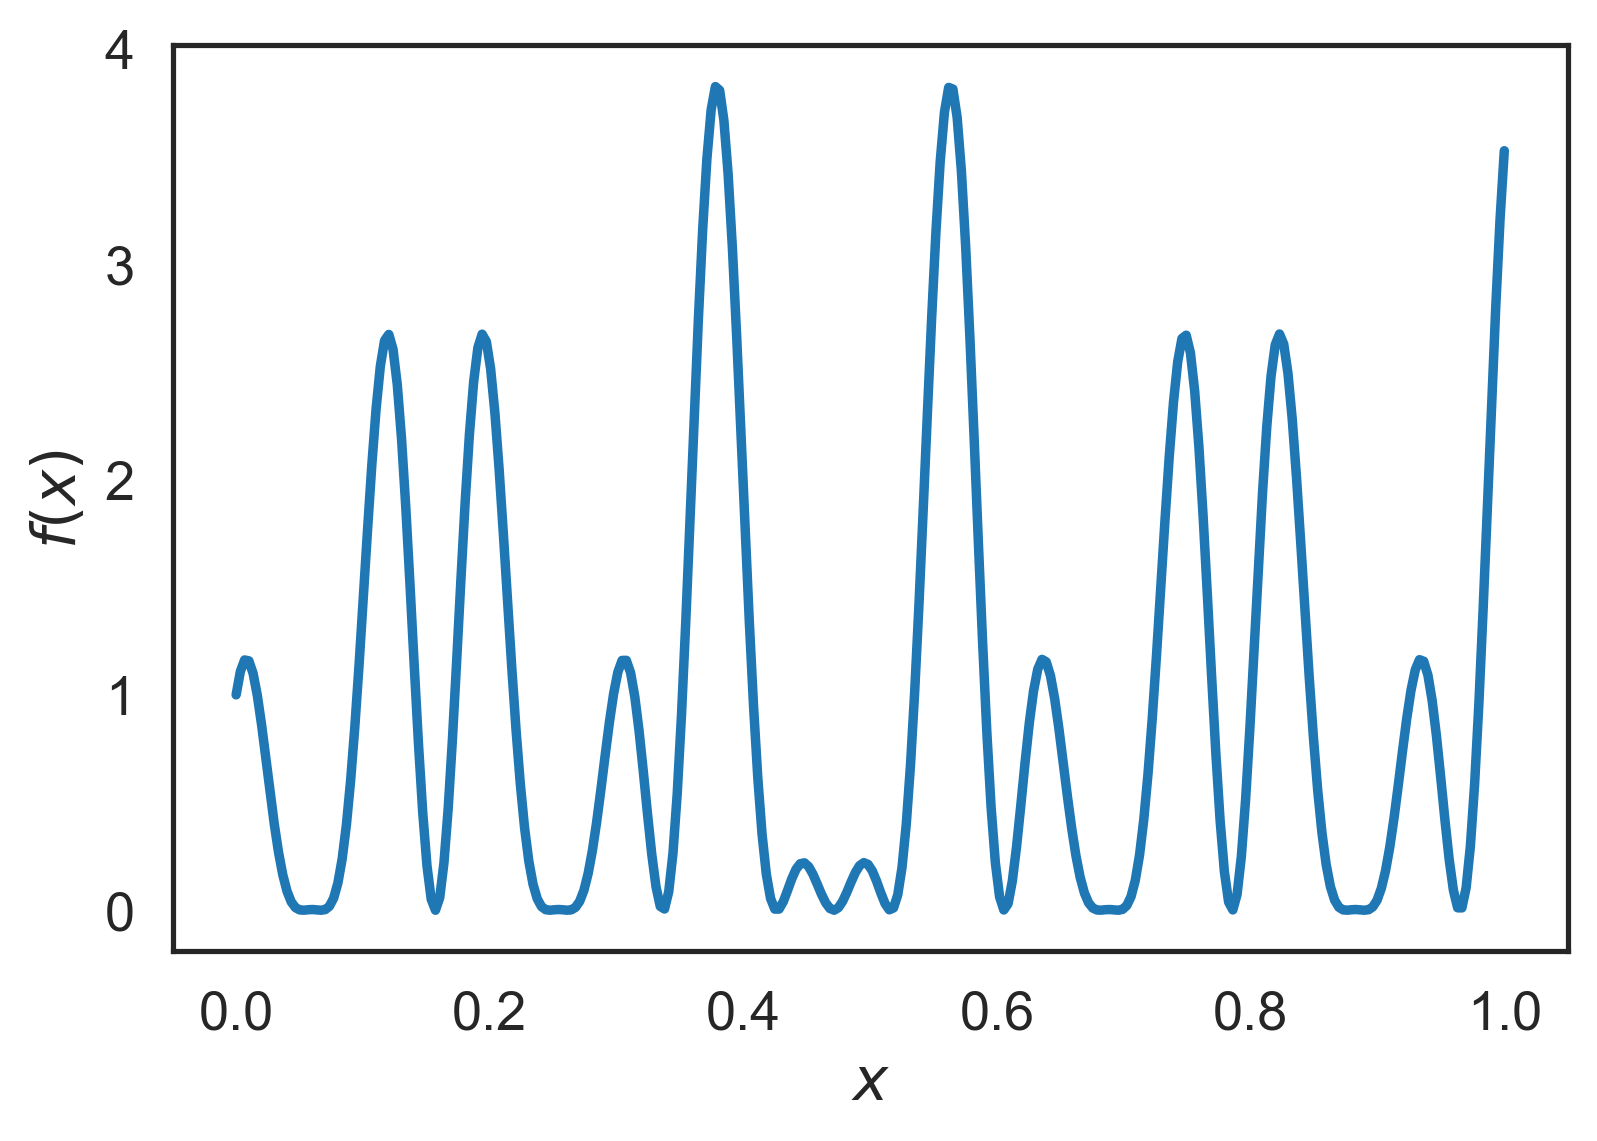

In [19]:
# Define the function
f = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2

# Let's visualize is first
fig, ax = plt.subplots()
x = np.linspace(0, 1, 300)
ax.plot(x, f(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$');

In [20]:
# Now let's implement the monte carlo procedure in a generic way
def get_mc_estimate(max_n=1000, func=f, dim=1, sampler=np.random.rand):
    """
    Return the the MC estimate of the 1D integral using the previously defined f function.
    Note that this only samples from the uniform distribution in ``dim`` dimensions.
    
    :param max_n:   Maximum number of samples.
    :param func:    The function to integrate.
    :parma dim:     The dimension of the input.
    :param sampler: A function that samples x's.
    """
    I = np.ndarray((max_n,))    # A running estimate of the expecation
    s = 0.                      # A variable to keep track of the sum
    for n in range(max_n):
        # sample an x
        x = sampler(dim)
        # evaluate f
        y = func(x)
        # Update the sum
        s += y
        # The current approximation of the integral is
        I[n] = s / (n + 1)
    return I

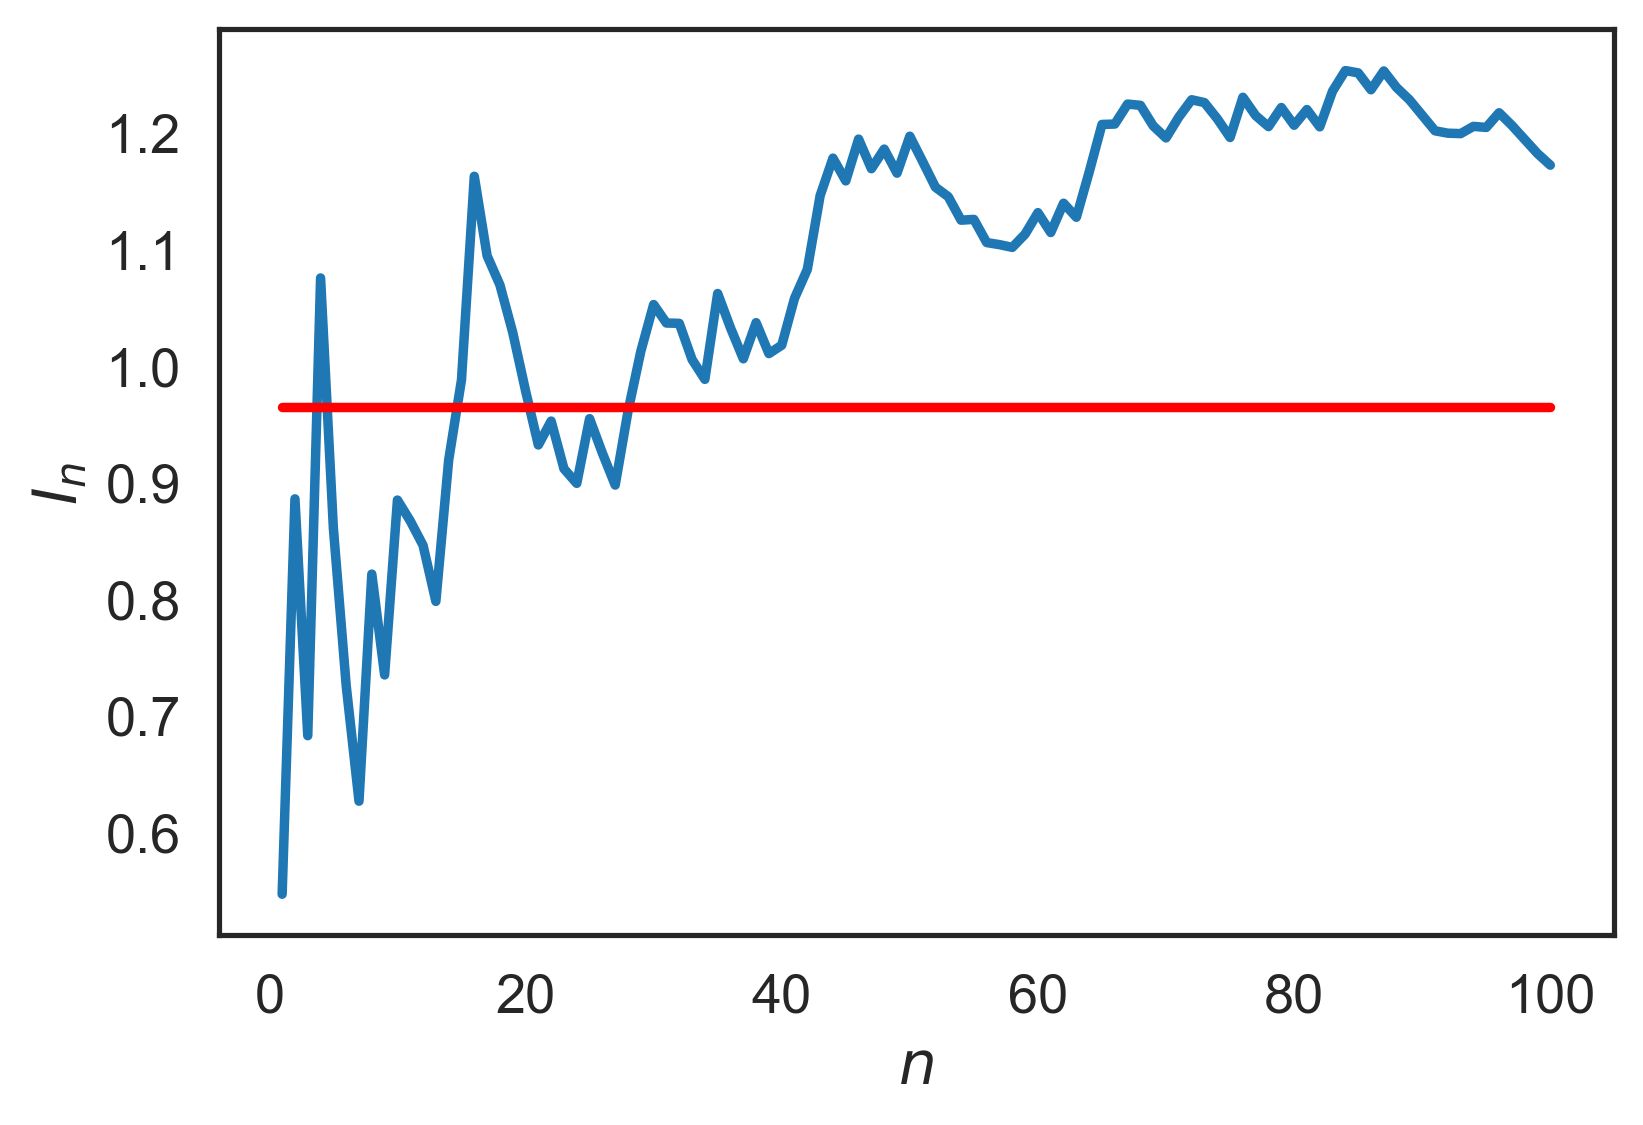

In [21]:
# Let's try running it
num_mc = 1   # How many times do you want to run MC
max_n = 100  # Maximum number of samples to take per MC run
fig, ax = plt.subplots()
for _ in range(num_mc):
    I = get_mc_estimate(max_n=max_n, func=f, dim=1)
    ax.plot(np.arange(1, max_n+1), I)
ax.plot(np.arange(1, max_n+1), [0.965] * max_n, color='r')
ax.set_xlabel('$n$')
ax.set_ylabel('$I_n$');

### Questions

+ Increase ``max_n`` until you get an answer that is close enough to the correct answer (the red line).
+ Reduce ``max_n`` back to a small number, say 1,000. Run the code 2-3 times to observe that every time you get a slightly different answer...
+ Set ``num_mc`` to 10 (or higher). Observe how different MC runs envelop the correct answer. This is epistemic uncertainty. How can we get it without running this repeatedly?

### Quantifying the Epistemic Uncertainty of an MC Estimate
The *Central Limit Theorem* comes to rescue.
It states that if $\mathbb{V}[f(X)]$ exists, then the empirical average:
$$
I_n:=\frac{1}{n}\sum_{j=1}^nf(X_j) \rightarrow \mathcal{N}\left(\mathbb{E}[f(X)], \frac{1}{n}\mathbb{V}[f(X)]\right),
$$
in distribution as $n\rightarrow \infty$.
This suggests that, the true expectation must be within two standard deviations of $I_n$, i.e.,
$$
I := \mathbb{E}[f(X)] = I_n \pm \frac{2}{\sqrt{m}}\mathbb{V}[f(X)].
$$
This is perfect, except from the fact that we don't really know what $\mathbb{V}[f(X)]$ is...
Well, let's approximate it also with MC!
Set:
$$
V_n = \frac{1}{n}\sum_{j=1}^n\left(f(X_j) - I_n\right)^2.
$$
Then we can say that:
$$
I = I_n \pm \frac{2}{\sqrt{n}}\sqrt{V_n}.
$$
Let's see if this works.

In [22]:
# Let's modify the previous function so that it also returns the variance estimate
def get_mc_estimate(max_n=1000, func=f, dim=1, sampler=np.random.rand):
    """
    Return the the MC estimate of the 1D integral using the previously defined f function.
    Note that this only samples from the uniform distribution in ``dim`` dimensions.
    
    :param max_n: Maximum number of samples.
    :param func:  The function to integrate.
    :parma dim:   The dimension of the input.
    """
    I = np.ndarray((max_n,))    # A running estimate of the expecation
    V = np.ndarray((max_n,))    # A running estimate of the epistemic variance
    s = 0.                      # A variable to keep track of the sum
    s2 = 0.                     # A variable to keep track of the sum of square centered differences
    for n in range(max_n):
        # sample an x
        x = sampler(dim)
        # evaluate f
        y = func(x)
        # Update the sum
        s += y
        # The current approximation of the integral is
        I[n] = s / (n + 1)
        # Update s2:
        s2 += (y - I[n]) ** 2
        # The current approximation of the epistemic variance
        V[n] = s2 / (n + 1)
    return I, V

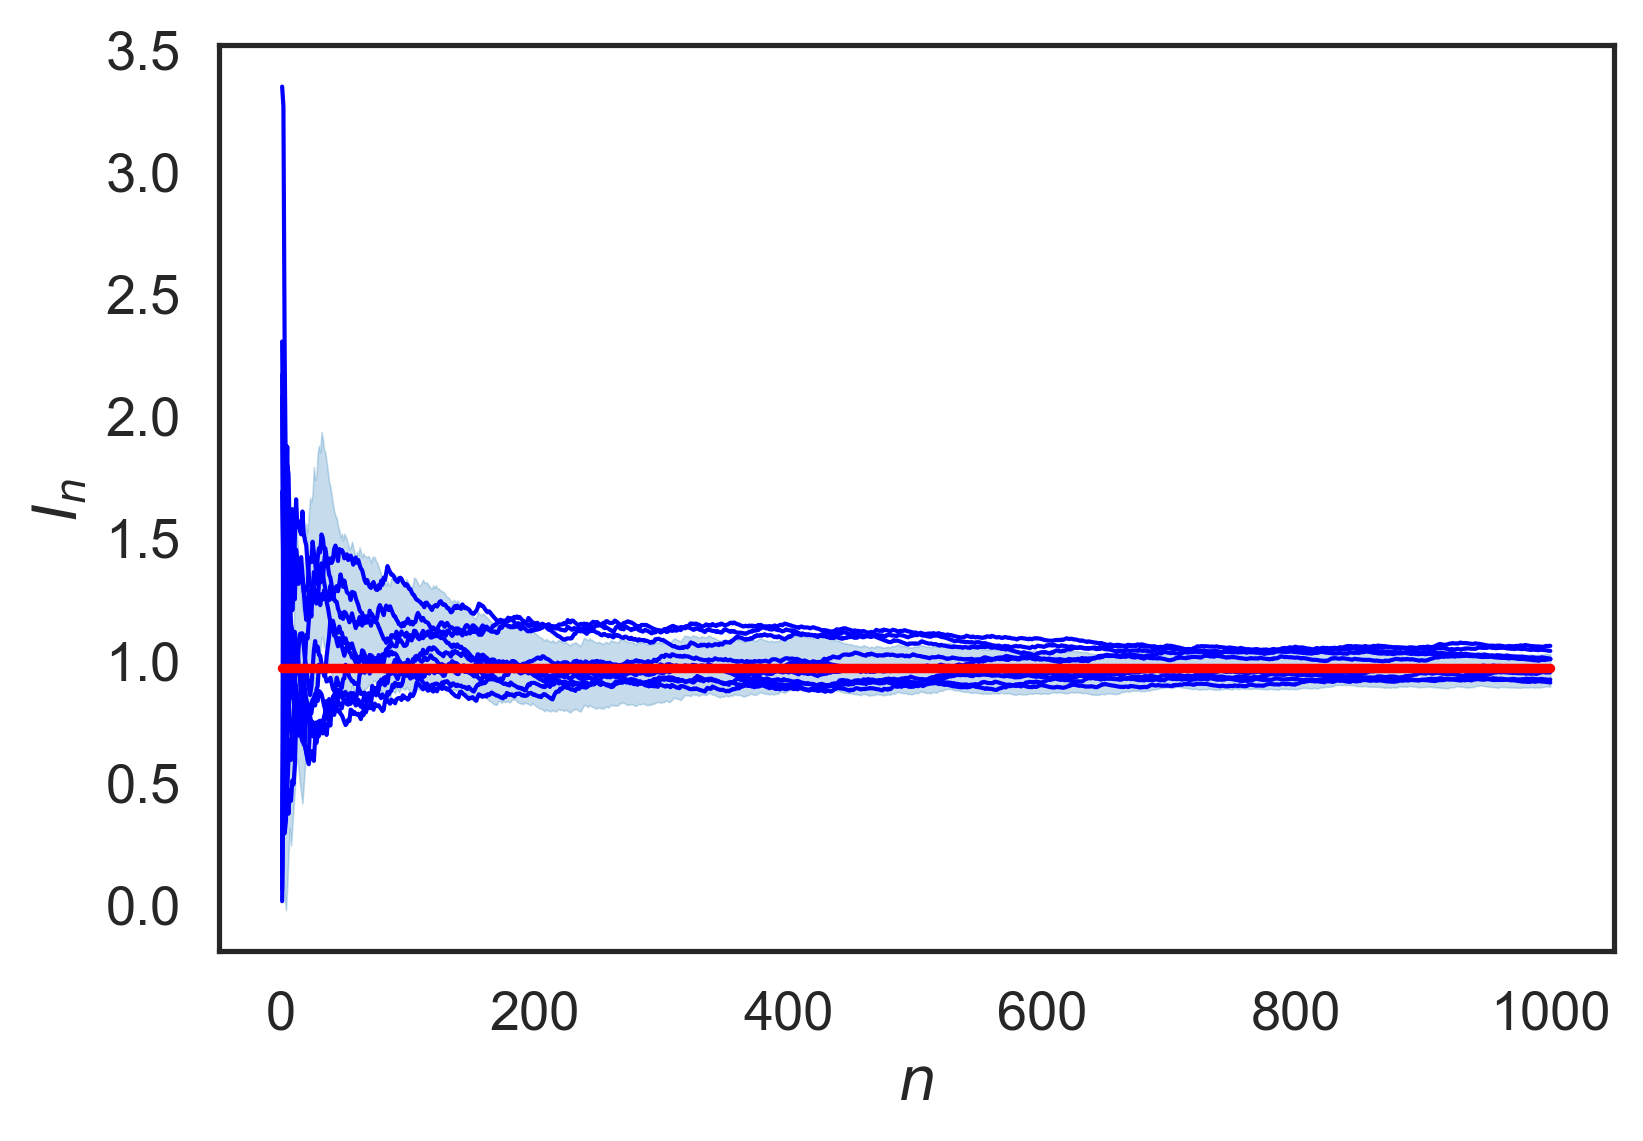

In [23]:
# Let's try running it
num_mc = 10   # How many times do you want to run MC
max_n = 1000  # Maximum number of samples to take per MC run
fig, ax = plt.subplots()
all_ns = np.arange(1, max_n+1)
for k in range(num_mc):
    I, V = get_mc_estimate(max_n=max_n, func=f, dim=1)
    ax.plot(all_ns, I, color='b', lw=1)
    # Plot the error bar only for the first mc run:
    if k == 0:
        # The lower bound
        l = I - 2. / np.sqrt(all_ns) * np.sqrt(V)
        # The upper bound
        u = I + 2. / np.sqrt(all_ns) * np.sqrt(V)
        ax.fill_between(np.arange(1, max_n+1), l, u, color=sns.color_palette()[0], alpha=0.25)
ax.plot(np.arange(1, max_n+1), [0.965] * max_n, color='r')
ax.set_xlabel('$n$')
ax.set_ylabel('$I_n$');

### Questions

+ Increase ``max_n`` until you get an answer that is close enough to the correct answer (the red line). Notice how the epistemic error bars shrink around the true value.
+ Reduce ``max_n`` back to a small number, say 1,000. Set ``num_mc`` to 10 (or higher). Observe how different MC runs envelop the correct answer. If the epistemic error bars were spot on, only 5 in 100 trajectories would be off. For which $n$ do the epistemic error bars look less accurate (small $n$ or big $n$)? Why do you think that is? Argue using the central limit theorem.

## Exaple: Propagating Uncertainty Through a Differential Equation
Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}T(x)\right) = 0,
$$
and boundary values:
$$
T(0) = 1\;\mbox{and}\;T(1) = 0.
$$
We are interested in cases in which we are uncertain about the conductivity, $c(x)$.
Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $c(x)$ that represents our uncertainty.
This requires assigning a probability measure on a function space (the subject of Lectures 7 to 12).
For now, we will just give you a model.
We will model $c = c(x;\boldsymbol{\xi})$ as:
$$
c(x;\boldsymbol{\xi}) = c_0(x)\exp\{g(x;\boldsymbol{\xi})\},
$$
where $c_0(x)$ is a "mean" conductivity level and $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $c(x;\boldsymbol{\xi})$ must be positive.
We will assume that the random field ia a [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
This is a field that it is no-where continuous and it is actually a fractal (when you zoom in the spatial dimension, the field resembles itself at a larger scale).
The Karhunen-Loeve expansion of the field is:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^\infty\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are the eigenfunctions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.
For the record, this corresponds to a random field known as the 
Since, we cannot actually work with the infinite sums, let's truncate at $i=d$ and define:
$$
g_d(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x).
$$
Let's implement the field:

In [24]:
# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   One dimensional vector containing the points at which you wish to evaluate the field.
    xi    -   One dimensional vector of the random variables. The dimensionality of this vector
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = np.zeros(x.shape[0])
    d = xi.shape[0]
    for i in xrange(d):
        res += xi[i] * np.sqrt(2) * sigma / (i - .5) / np.pi * np.sin((i - .5) * np.pi * x)
    return res

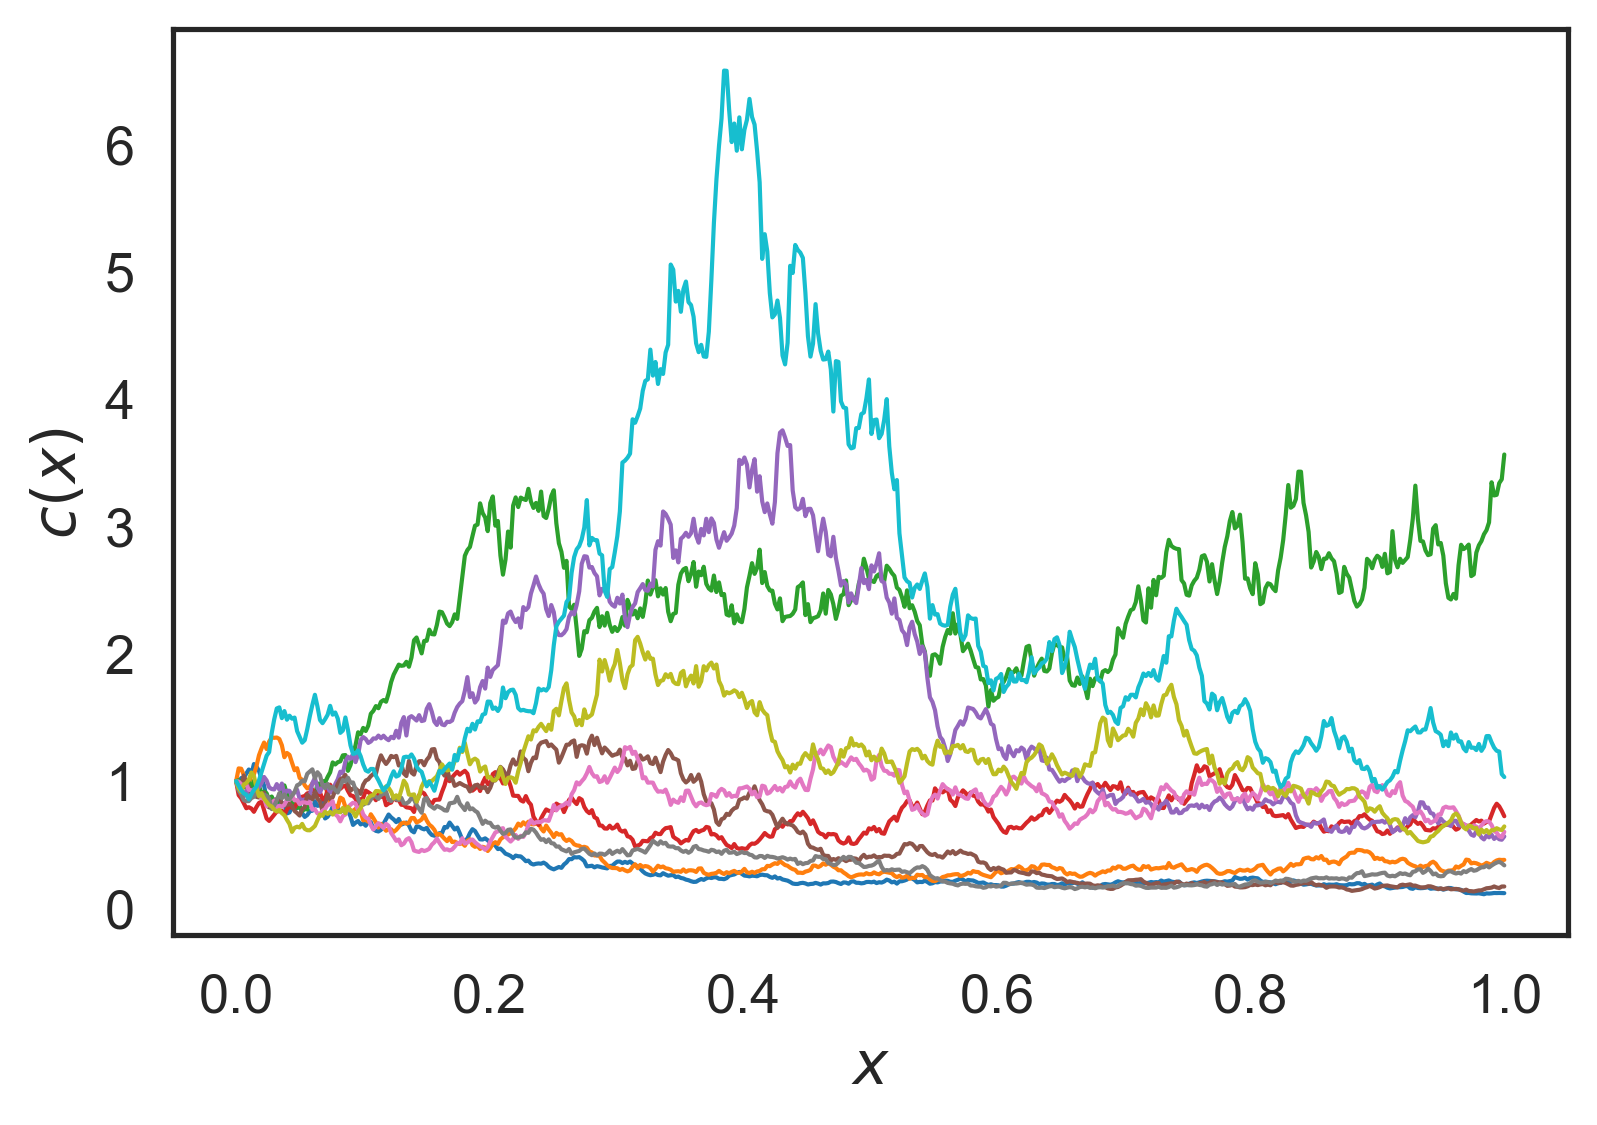

In [25]:
x = np.linspace(0, 1, 500)
d = 1000
fig, ax = plt.subplots()
for i in xrange(10):
    xi = np.random.randn(d)
    ax.plot(x, np.exp(g(x, xi)), linewidth=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$c(x)$');

### Questions

+ To get an accurate description of the field, you need to include a lot of dimensions. $d=10$ is not enough. Start increasing $d$ from $10$ to $100$ to $1000$.

## Constructing a Solver for the Boundary Value Problem

Let's return to our stochastic boundary value problem.
We need to create a solver. We will develop a solver based on the [finite volume method](https://en.wikipedia.org/wiki/Finite_volume_method) using [FiPy](http://www.ctcms.nist.gov/fipy).
You have to install the following packages:
```
pip install ez_setup
pip install fipy
```
Here is the solver:

In [26]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, g=g, nx=100, value_left=1., value_right=0.):
        self.g = g
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        g_val = self.g(x, xi)
        self.C.setValue(np.exp(g_val))
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()

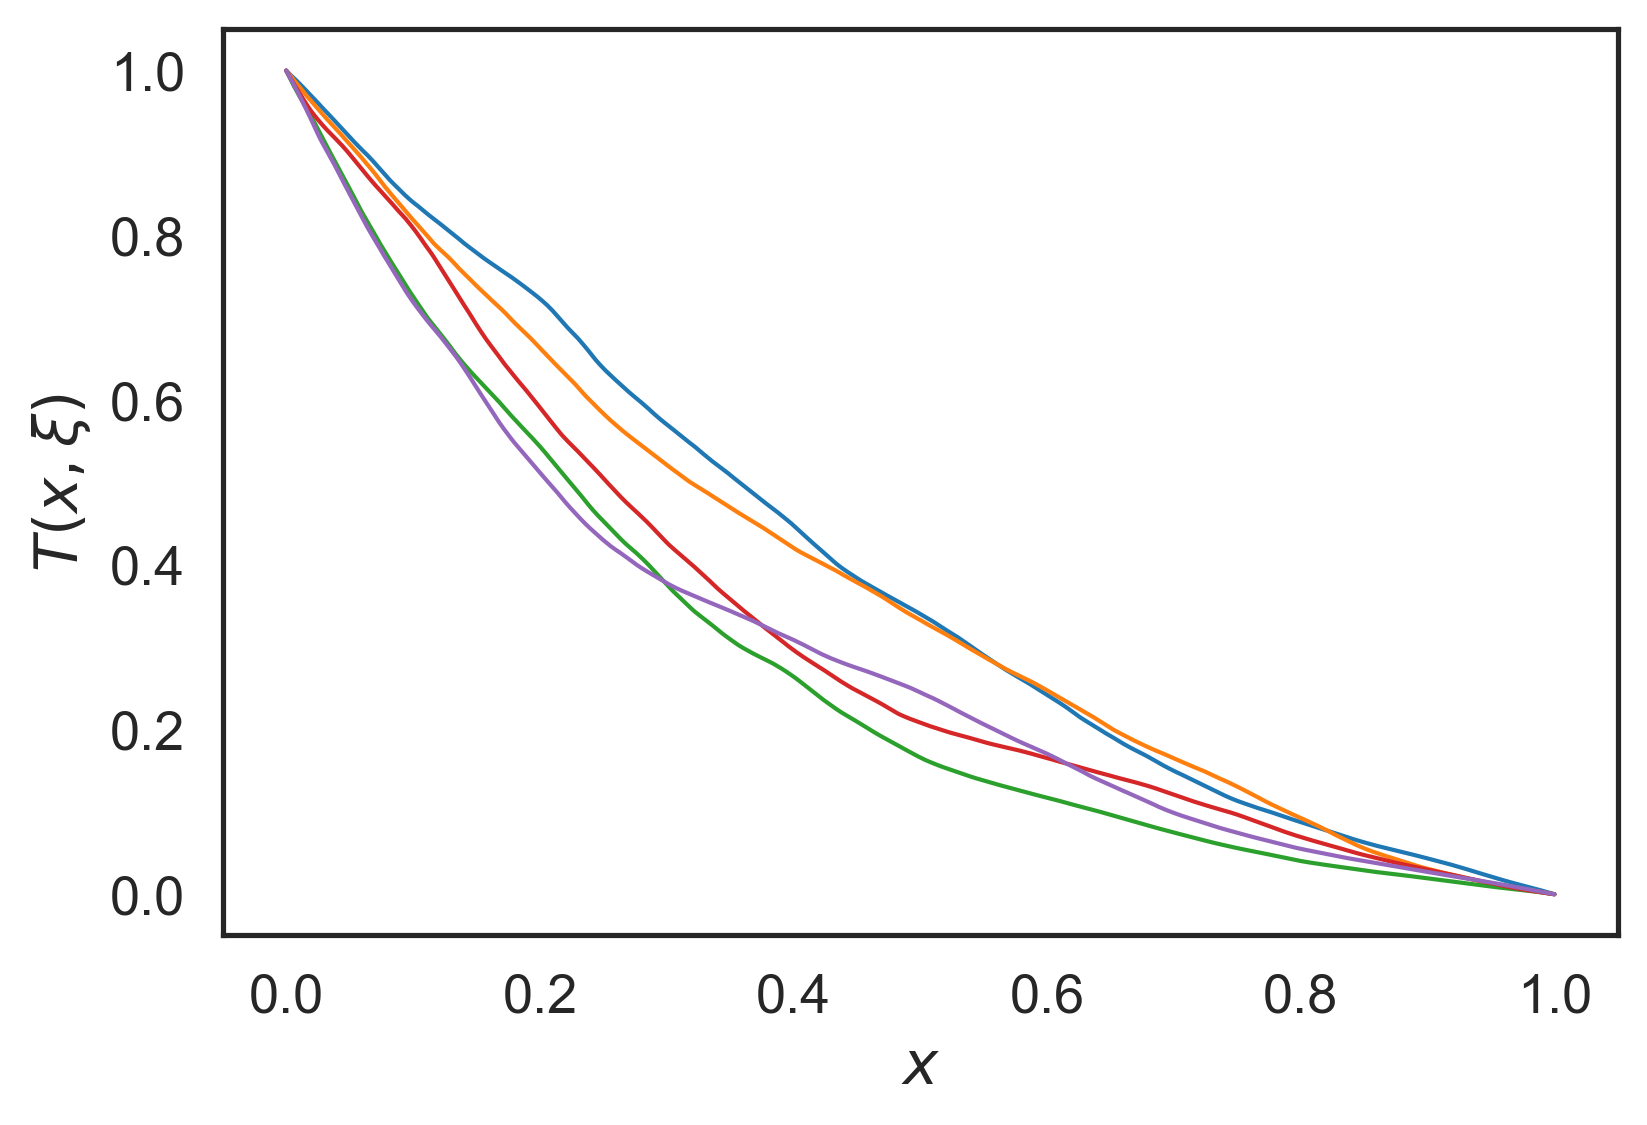

In [27]:
solver = SteadyStateHeat1DSolver(nx=500)
d = 1000
fig, ax = plt.subplots()
for i in xrange(5):
    xi = np.random.randn(1000)
    x, y = solver(xi)
    ax.plot(x, y, lw=1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$T(x,\xi)$');

Let's now use Monte Carlo to estimate the mean of $T(x)$ at a single point, say $x=0.5$:
$$
T_m(x=0.5) = \mathbb{E}_\xi[T(x=0.5,\xi)].
$$
We will slightly modify our previous code.
We start by defining a function $f (\xi) = T(x=0.5, \xi)$:

In [28]:
f_solver = lambda xi: solver(xi)[1][solver.nx / 2]    # Solve the problem at xi, grab the mid point of the solution array

Now we are ready to repeat our MC analysis. This is going to take a while.

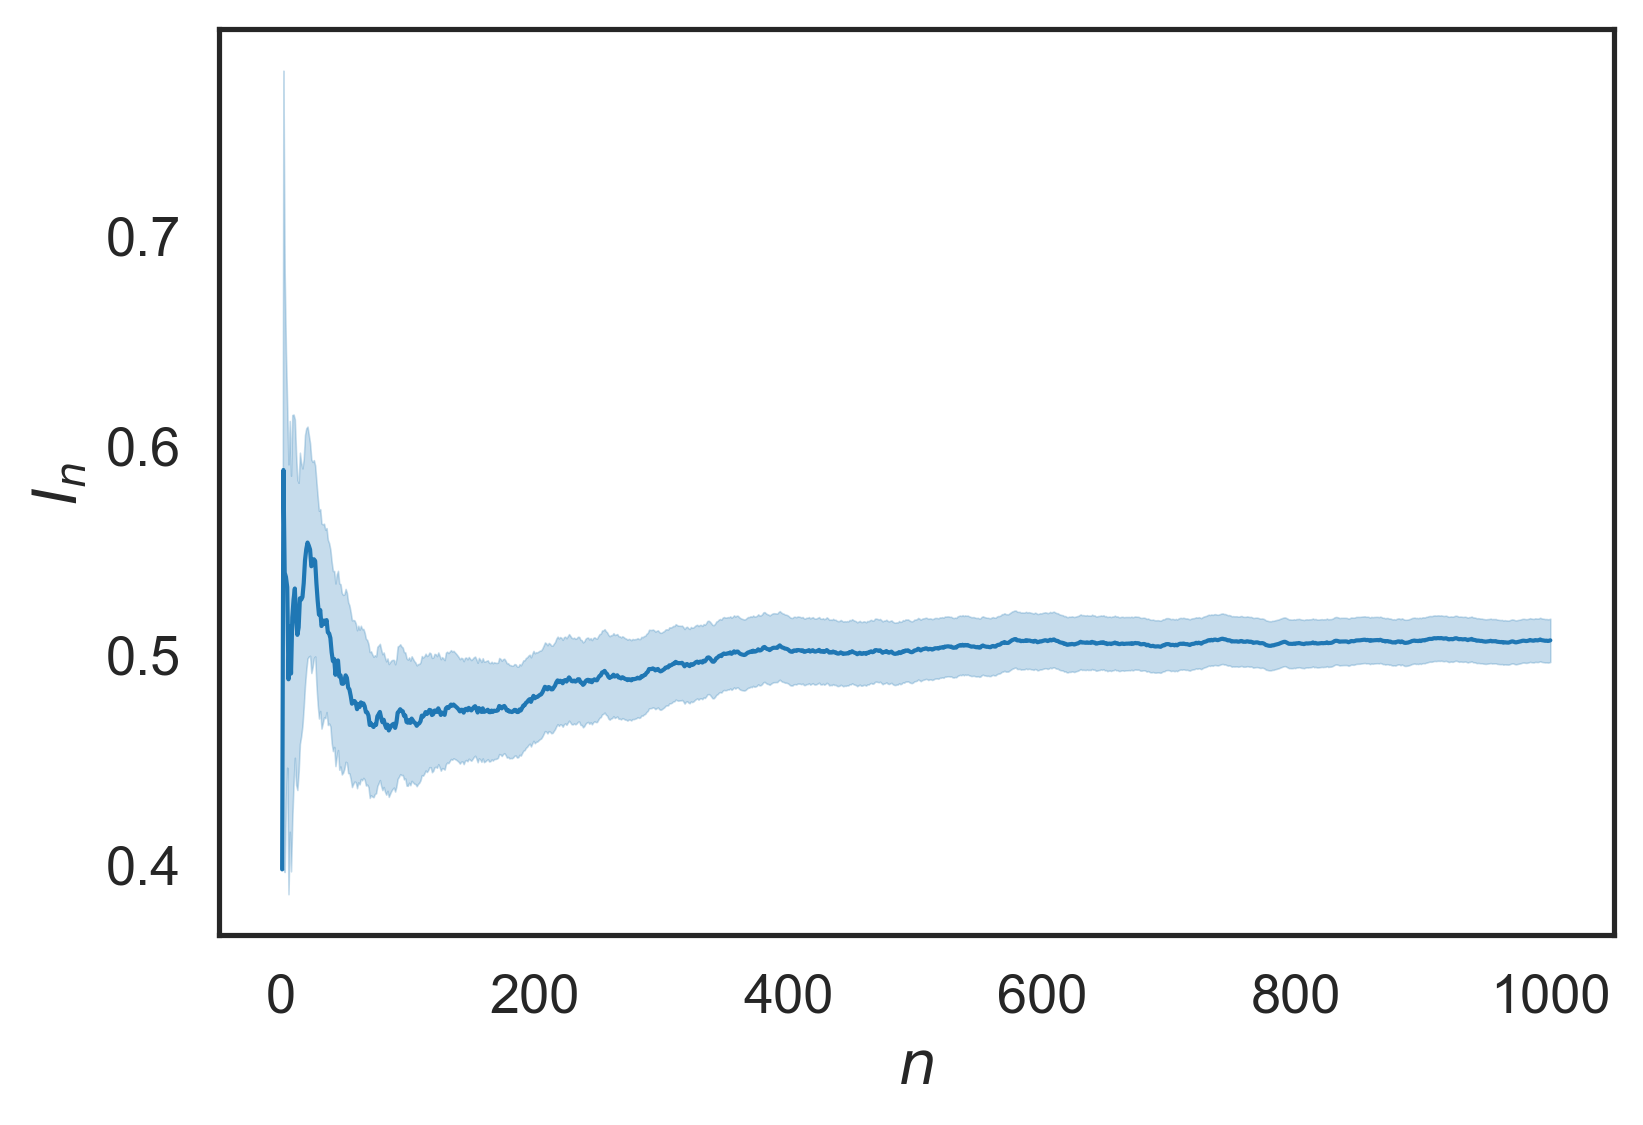

In [29]:
d = 1000      # Dimensionality of the random field
max_n = 1000  # Maximum number of samples to take per MC run
fig, ax = plt.subplots()
all_ns = np.arange(1, max_n+1)
I, V = get_mc_estimate(max_n=max_n, func=f_solver, dim=d, sampler=np.random.randn) # Notice that I changed the sampler
ax.plot(all_ns, I, lw=1)
# The lower bound
l = I - 2. / np.sqrt(all_ns) * np.sqrt(V)
# The upper bound
u = I + 2. / np.sqrt(all_ns) * np.sqrt(V)
ax.fill_between(np.arange(1, max_n+1), l, u, color=sns.color_palette()[0], alpha=0.25)
ax.set_xlabel('$n$')
ax.set_ylabel('$I_n$');

Let's do something more exiting.
Let's find upper and lower bounds for the solution.
To achieve this, we will use the empirical percentiles of a large number of samples.

In [30]:
d = 1000 # Dimensionality of the field
max_n = 1000 # How many samples do you want to use?
# Array to store the data we collect
data = np.ndarray((max_n, solver.nx + 1))
for i in range(max_n):
    xi = np.random.randn(d)
    data[i, :] = solver(xi)[1]

First, let us find the median of $T(x,\xi)$ for each $x$.
The median $\mu(x)$ is defined so that
$$
\mathbb{P}_\xi\left[T(x,\xi) \le \mu(x)\right] = 0.5.
$$
We can find it by:

In [31]:
mu = np.median(data, axis=0)

In general, the $q$-th percentile is defined by:
$$
\mathbb{P}_\xi\left[T(x,\xi)\le \mu_q(x)\right] = \frac{q}{100}.
$$
Of particular interest are the $2.5\%$ and the $97.5\%$ quantiles:
$$
\mathbb{P}_\xi\left[T(x,\xi)\le \mu_{2.5}(x)\right] = \frac{2.5}{100},
$$
and
$$
\mathbb{P}_\xi\left[T(x,\xi)\le \mu_{97.5}(x)\right] = \frac{97.5}{100},
$$
respectively.
These can be found by:

In [32]:
mu_025 = np.percentile(data, 2.5, axis=0)
mu_975 = np.percentile(data, 97.5, axis=0)

Using them, you can define a $95\%$ *prediction interval* for your estimate since:
$$
\mathbb{P}_\xi(\mu_{2.5}(x) \le T(x,\xi) \le \mu_{97.5}(x)) = 0.95.
$$
Of course, you should keep in mind that since we are using a finite number of samples, there is residual epistemic uncertainty in these estimates.
You should only trust them if you have convergent results.
Let's visualize them:

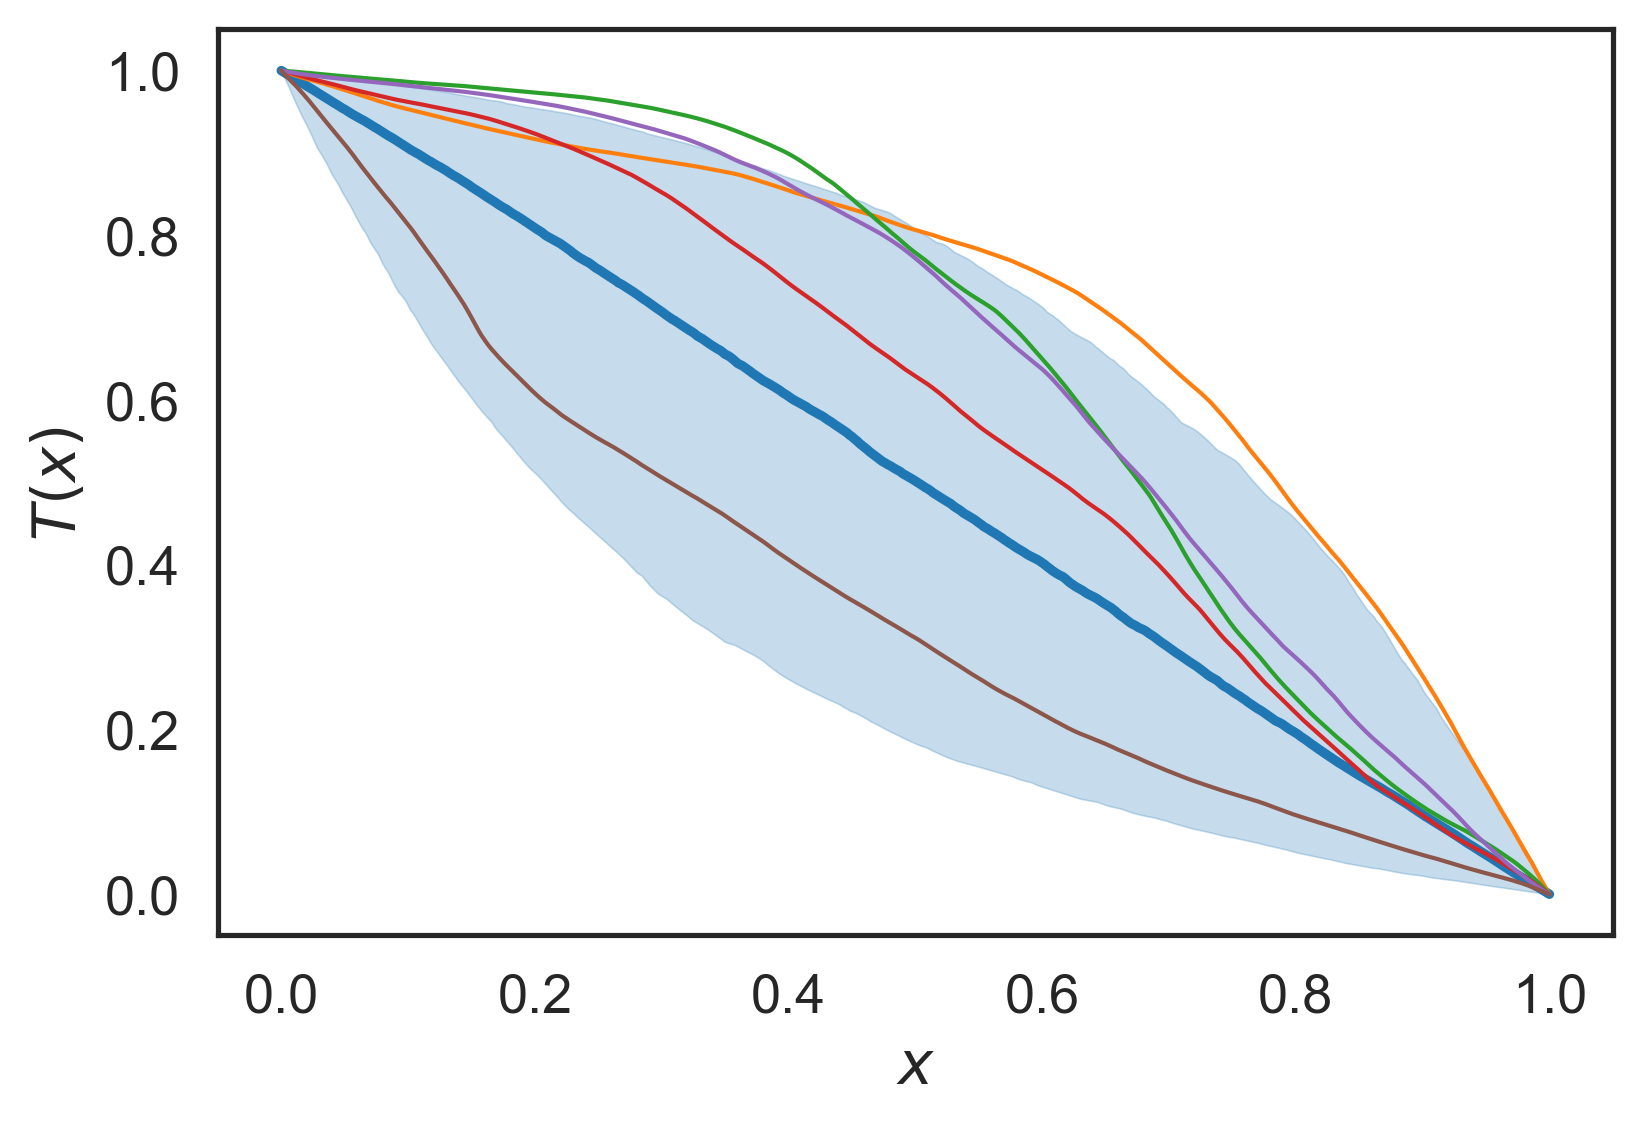

In [33]:
fig, ax = plt.subplots()
ax.plot(x, mu)
ax.fill_between(x, mu_025, mu_975, color=sns.color_palette()[0], alpha=0.25)
# Let's take a couple of samples and see if they fall inside:
for _ in range(5):
    xi = np.random.randn(d)
    y = solver(xi)[1]
    ax.plot(x, y, lw=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$T(x)$');

### Questions

+ Monte Carlo seems kind of slow. Where do you think is the bottleneck? What can be done to accelerate it?
+ One idea is to parallelize Monte Carlo. How would you go about doing this?
+ Another idea would be to replace the solver with a regression surface. Have we learned any techniques in class so far that can be used for this purpose? Do these techniques work when the input is high-dimensional?
+ Modify the code above to plot a series of quantiles that will give you an idea of the underlying probability density on the space of $T(x)$'s. Plot the $5, 10, 15, 20, 25, 30, 35,\ldots, 80, 85, 90, 95\%$ quantiles.
+ Use the data you have collected in ``data`` to estimate the probability that $T(x=0.5)$ is greater than $0.8$:
$$
\mathbb{P}_\xi\left[T(x=0.5,\xi)\ge 0.8\right] = \mathbb{E}_\xi\left[1_{[0.8,\infty]}(T(x=0.5,\xi))\right].
$$
Write your code below.

In [ ]:
def h(xi):
    """
    Define this to be the indicator function in order to take the expectation you need.
    """
    # Here is how you can get T(x=0.5, xi)):
    y = solver(xi)[1][solver.nx / 2]
    # Write your code below here:
    pass

max_n = 1000  # Maximum number of samples to take per MC run
fig, ax = plt.subplots()
all_ns = np.arange(1, max_n+1)
I, V = get_mc_estimate(max_n=max_n, func=h, dim=d, sampler=np.random.randn) # Notice that I changed the sampler
ax.plot(all_ns, I, lw=1)
# The lower bound
l = I - 2. / np.sqrt(all_ns) * np.sqrt(V)
# The upper bound
u = I + 2. / np.sqrt(all_ns) * np.sqrt(V)
ax.fill_between(np.arange(1, max_n+1), l, u, color=sns.color_palette()[0], alpha=0.25)
ax.set_xlabel('$n$')
ax.set_ylabel('$I_n$');